# Evaluating truth vs sourmash gather



In [1]:
import csv
import sys
sys.path.insert(0, '../2018-ncbi-lineages/')
import ncbi_taxdump_utils
import os
from pprint import pprint

in ../2018-ncbi-lineages

    mkdir genbank

    cd genbank/

    curl -L -O ftp://ftp.ncbi.nih.gov/pub/taxonomy//taxdmp.zip
    unzip taxdmp.zip nodes.dmp names.dmp
    rm taxdmp.zip


In [2]:
taxfoo = ncbi_taxdump_utils.NCBI_TaxonomyFoo()

taxfoo.load_nodes_dmp('../2018-ncbi-lineages/genbank/nodes.dmp')
taxfoo.load_names_dmp('../2018-ncbi-lineages/genbank/names.dmp')

want_taxonomy = ['superkingdom', 'phylum', 'order', 'class', 'family', 'genus', 'species']

In [3]:
from sourmash.lca import lca_utils, command_index

def format_lineage(lineage_tup):
    return ";".join(lca_utils.zip_lineage(lineage_tup))

# Sourmash gather: mapping from accession -> lineages
This is important for dealing with the CSV output of sourmash gather; sourmash lca gather comes with the taxonomy already in the CSV output.

In [4]:
acc_to_lineage, num_rows = command_index.load_taxonomy_assignments('gather-lineages.csv', start_column=3)
print('loaded {} rows'.format(num_rows))

loaded 1027 rows


examining spreadsheet headers...
** assuming column 'accession' is identifiers in spreadsheet


In [5]:
def get_lineage_by_acc(acc):
    acc = acc.split(' ')[0].split('.')[0]
    return acc_to_lineage.get(acc, None)

# example for 'get_lineage_by_acc'
#lineage = get_lineage_by_acc('NC_000917')
#print(lineage)
#print(format_lineage(lineage))

In [6]:
def load_sourmash_csv(filename):
    with open(filename, 'rt') as fp:
        r = csv.DictReader(fp)
        rows = list(r)
    return rows

load_sourmash_csv('output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')[:1]

[OrderedDict([('intersect_bp', '330000'),
              ('f_orig_query', '0.008465879938429965'),
              ('f_match', '0.03466386554621849'),
              ('f_unique_to_query', '0.008465879938429965'),
              ('f_unique_weighted', '0.008465879938429965'),
              ('average_abund', '1.0'),
              ('name',
               'NC_013132.1 Chitinophaga pinensis DSM 2588, complete genome'),
              ('filename', 'inputs/databases/genbank-k51.sbt.json'),
              ('md5:x ', 'd06a405d39c8ebed579540db2994afe8')])]

In [7]:
notfound = set()
def make_gather_lineages(filename):
    rows = load_sourmash_csv(filename)
    rows2 = []
    for d in rows:
        name = d['name']
        lineage = get_lineage_by_acc(name)
        if lineage is None:
            print('ZZZ found no lineage for {}'.format(name))
            notfound.add(name)
            continue
        lineage = [x for x in lineage if x.rank != "strain"]
        lineage = tuple(lineage)
        d2 = dict(d)
        d2['lineage'] = lineage
        rows2.append(d2)
        
    return rows2

make_gather_lineages('output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')[:1]

[{'average_abund': '1.0',
  'f_match': '0.03466386554621849',
  'f_orig_query': '0.008465879938429965',
  'f_unique_to_query': '0.008465879938429965',
  'f_unique_weighted': '0.008465879938429965',
  'filename': 'inputs/databases/genbank-k51.sbt.json',
  'intersect_bp': '330000',
  'lineage': (LineagePair(rank='superkingdom', name='Bacteria'),
   LineagePair(rank='phylum', name='Bacteroidetes'),
   LineagePair(rank='class', name='Chitinophagia'),
   LineagePair(rank='order', name='Chitinophagales'),
   LineagePair(rank='family', name='Chitinophagaceae'),
   LineagePair(rank='genus', name='Chitinophaga'),
   LineagePair(rank='species', name='Chitinophaga pinensis')),
  'md5:x ': 'd06a405d39c8ebed579540db2994afe8',
  'name': 'NC_013132.1 Chitinophaga pinensis DSM 2588, complete genome'}]

## Truth files: loading in & fleshing out NCBI taxonomy
From McIntyre et al. 2018 https://ftp-private.ncbi.nlm.nih.gov/nist-immsa/IMMSA/

In [8]:
def load_truth_file(filename):
    with open(filename, 'rt') as fp:
        lines = fp.readlines()
        
    lines = [ x.strip() for x in lines ]
    lines = [ x.split('\t') for x in lines ]
    
    rows = []
    for x in lines:
        taxid, a, b, rank, name = x
        taxid = int(taxid)
        rows.append((taxid, a, b, rank, name))
    return rows
    
print(load_truth_file('truth_sets/species/Huttenhower_HC1_TRUTH.txt')[:5])

[(84980, '1.00000', '0.01000', 'species', 'Desulfotalea psychrophila'), (1428, '1.00000', '0.01000', 'species', 'Bacillus thuringiensis'), (1496, '1.00000', '0.01000', 'species', 'Peptoclostridium difficile'), (1525, '1.00000', '0.01000', 'species', 'Moorella thermoacetica'), (1423, '1.00000', '0.01000', 'species', 'Bacillus subtilis')]


In [9]:
def make_lineage_from_taxid(taxid):
    lineage_d = taxfoo.get_lineage_as_dict(taxid, want_taxonomy)
    
    lineage = []
    for rank in lca_utils.taxlist():
        if rank == 'strain': continue 
        name = lineage_d.get(rank, 'unassigned')
        lineage_pair = lca_utils.LineagePair(rank, name)
        lineage.append(lineage_pair)
    return tuple(lineage)

make_lineage_from_taxid(84980)

(LineagePair(rank='superkingdom', name='Bacteria'),
 LineagePair(rank='phylum', name='Proteobacteria'),
 LineagePair(rank='class', name='Deltaproteobacteria'),
 LineagePair(rank='order', name='Desulfobacterales'),
 LineagePair(rank='family', name='Desulfobulbaceae'),
 LineagePair(rank='genus', name='Desulfotalea'),
 LineagePair(rank='species', name='Desulfotalea psychrophila'))

In [10]:
def make_truth_lineages(filename):
    rows = load_truth_file(filename)
    
    rows2 = []
    for (taxid, a, b, rank, name) in rows:
        lineage = make_lineage_from_taxid(taxid)
        rows2.append((taxid, a, b, rank, name, lineage))
        for lintup in lineage:
            if lintup.rank == rank:
                if lintup.name != name:
                    print('DISAGREE: ncbi={}, truthfile={}'.format(lintup.name, name))
    return rows2

truth_lineages = make_truth_lineages('truth_sets/species/Huttenhower_HC1_TRUTH.txt')
print(truth_lineages[:1])

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
[(84980, '1.00000', '0.01000', 'species', 'Desulfotalea psychrophila', (LineagePair(rank='superkingdom', name='Bacteria'), LineagePair(rank='phylum', name='Proteobacteria'), LineagePair(rank='class', name='Deltaproteobacteria'), LineagePair(rank='order', name='Desulfobacterales'), LineagePair(rank='family', name='Desulfobulbaceae'), LineagePair(rank='genus', name='Desulfotalea'), LineagePair(rank='species', name='Desulfotalea psychrophila')))]


## Sourmash gather: mapping from accession -> lineages

## Load LCA gather csv files

In [11]:
def make_lca_gather_lineages(filename):
    rows = load_sourmash_csv(filename)
    rows2 = []
    for d in rows:
        d2 = dict(d)
        
        lineage = []
        for rank in lca_utils.taxlist():
            if rank in d2:
                name = d2.get(rank)
                del d2[rank]
                lineage.append((rank, name))
                
        lineage = [ lca_utils.LineagePair(r, n) for (r, n) in lineage ]
        d2['lineage'] = tuple(lineage)
        rows2.append(d2)
        
    return rows2

make_lca_gather_lineages('output/Huttenhower_HC1.fasta.gz.scaled10k.k51.lca.gather.matches.csv')[:1]

[{'average_abund': '1.0',
  'f_unique_to_query': '0.013083632632119035',
  'f_unique_weighted': '0.013083632632119035',
  'intersect_bp': '510000',
  'lineage': (LineagePair(rank='superkingdom', name='Bacteria'),
   LineagePair(rank='phylum', name='Firmicutes'),
   LineagePair(rank='class', name='Bacilli'),
   LineagePair(rank='order', name='Bacillales'),
   LineagePair(rank='family', name='Bacillaceae'),
   LineagePair(rank='genus', name='Bacillus'),
   LineagePair(rank='species', name='Bacillus subtilis'))}]

In [12]:
ls

README.md                     gather-lineages.csv
Untitled.ipynb                get-names-from-gather-csv.py*
brooks-lineages.txt.taxid     output/
foo.csv                       parse.ipynb
gather-accessions.txt         tax_id.txt.taxid
gather-accessions.txt.taxid   truth_sets/
gather-lineages


In [13]:
ls output/Huttenhower_HC1*

output/Huttenhower_HC1.fasta.gz.scaled10k.k51.lca.gather.matches.csv
output/Huttenhower_HC1.fasta.gz_contigs.scaled10k.k51.lca.gather.matches.csv
output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv
output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv


In [14]:
ls truth_sets/species/Huttenhower_HC1*

truth_sets/species/Huttenhower_HC1_TRUTH.txt


In [15]:
def compare_gather_to_truth(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_gather_lineages(gather_csv)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    print(len(truth_lineages.intersection(gather_lineages)))
    print(len(truth_lineages.union(gather_lineages)))
    
    print(len(truth_lineages))
    
    print('** in gather but not truth:')
    for diff in gather_lineages - truth_lineages:
        print('\t', format_lineage(diff))
    
    print('\n** in truth but not gather:')
    for diff in truth_lineages - gather_lineages:
        print('\t', format_lineage(diff))
    
compare_gather_to_truth('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')


DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
92
102
100
** in gather but not truth:
	 Bacteria;Firmicutes;Bacilli;Lactobacillales;Lactobacillaceae;Lactobacillus;Lactobacillus gallinarum;
	 Bacteria;Chloroflexi;Chloroflexia;Chloroflexales;Chloroflexaceae;Chloroflexus;Chloroflexus sp. Y-400-fl;

** in truth but not gather:
	 Bacteria;Tenericutes;Mollicutes;Mycoplasmatales;Mycoplasmataceae;Ureaplasma;Ureaplasma urealyticum;
	 Archaea;Crenarchaeota;Thermoprotei;Thermoproteales;Thermoproteaceae;Pyrobaculum;Pyrobaculum arsenaticum;
	 Bacteria;Proteobacteria;Gammaproteobacteria;unassigned;unassigned;unassigned;Candidatus Baumannia cicadellinicola;
	 Bacteria;Tenericutes;Mollicutes;Mycoplasmatales;Mycoplasmataceae;Mycoplasma;Mycoplasma crocodyli;
	 Bacteria;Proteobacteria;Alphaproteobacteria;Rickettsiales;Anaplasmataceae;Anaplasma;Anaplasma centrale;
	 Bacteria;Firmicutes;Bacilli;

In [16]:
def compare_lca_gather_to_truth(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_lca_gather_lineages(gather_csv)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    print(len(truth_lineages.intersection(gather_lineages)))
    print(len(truth_lineages.union(gather_lineages)))
    
    print(len(truth_lineages))
    
    print('** in gather but not truth:')
    for diff in gather_lineages - truth_lineages:
        print('\t', format_lineage(diff))
    
    print('\n** in truth but not gather:')
    for diff in truth_lineages - gather_lineages:
        print('\t', format_lineage(diff))
    
compare_lca_gather_to_truth('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv')


DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
97
106
100
** in gather but not truth:
	 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Hafniaceae;Edwardsiella;Edwardsiella piscicida;
	 Bacteria;Proteobacteria;Betaproteobacteria;Rhodocyclales;Rhodocyclaceae;Dechloromonas;Dechloromonas aromatica;
	 Bacteria;Proteobacteria;Gammaproteobacteria;Vibrionales;Vibrionaceae;Vibrio;Vibrio hyugaensis;
	 Bacteria;Firmicutes;Bacilli;Bacillales;Bacillaceae;Bacillus;Bacillus sp. GZT;
	 Bacteria;Firmicutes;Bacilli;Lactobacillales;Lactobacillaceae;Lactobacillus;Lactobacillus gallinarum;
	 Bacteria;Proteobacteria;Epsilonproteobacteria;Campylobacterales;Helicobacteraceae;Helicobacter;Helicobacter pylori;

** in truth but not gather:
	 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Hafniaceae;Edwardsiella;Edwardsiella tarda;
	 Bacteria;Firmicutes;Bacilli;Bacillales;Ba

In [17]:
def compare_lca_gather_to_gather(lca_gather_csv, gather_csv):
    reg_gather = make_gather_lineages(gather_csv)
    lca_gather = make_lca_gather_lineages(lca_gather_csv)
    
    reg_gather_lineages = set([ row['lineage'] for row in reg_gather ])
    lca_gather_lineages = set([ row['lineage'] for row in lca_gather ])
    
    print(len(lca_gather_lineages.intersection(reg_gather_lineages)))
    print(len(lca_gather_lineages.union(reg_gather_lineages)))
        
    print('** in lca_gather but not reg gather:')
    for diff in lca_gather_lineages - reg_gather_lineages:
        print('\t', format_lineage(diff))
    
    print('\n** in gather but not lca gather:')
    for diff in reg_gather_lineages - lca_gather_lineages:
        print('\t', format_lineage(diff))
    
compare_lca_gather_to_gather('output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv',
                            'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')


90
107
** in lca_gather but not reg gather:
	 Bacteria;Tenericutes;Mollicutes;Mycoplasmatales;Mycoplasmataceae;Ureaplasma;Ureaplasma urealyticum;
	 Bacteria;Proteobacteria;Gammaproteobacteria;Enterobacterales;Hafniaceae;Edwardsiella;Edwardsiella piscicida;
	 Bacteria;Proteobacteria;Epsilonproteobacteria;Campylobacterales;Helicobacteraceae;Helicobacter;Helicobacter pylori;
	 Bacteria;Proteobacteria;Betaproteobacteria;Rhodocyclales;Rhodocyclaceae;Dechloromonas;Dechloromonas aromatica;
	 Archaea;Crenarchaeota;Thermoprotei;Thermoproteales;Thermoproteaceae;Pyrobaculum;Pyrobaculum arsenaticum;
	 Bacteria;Proteobacteria;Gammaproteobacteria;unassigned;unassigned;unassigned;Candidatus Baumannia cicadellinicola;
	 Bacteria;Tenericutes;Mollicutes;Mycoplasmatales;Mycoplasmataceae;Mycoplasma;Mycoplasma crocodyli;
	 Bacteria;Proteobacteria;Alphaproteobacteria;Rickettsiales;Anaplasmataceae;Anaplasma;Anaplasma centrale;
	 Bacteria;Proteobacteria;Gammaproteobacteria;Vibrionales;Vibrionaceae;Vibrio;Vibr

In [18]:
all_truth = """ABRF_MGRG_10ng_TRUTH.txt
ABRF_MGRG_1ng_TRUTH.txt
ABRF_MGRG_5ng_TRUTH.txt
ABRF_MGRG_Half_TRUTH.txt
ABRF_MGRG_Normal_TRUTH.txt
ABRF_MGRG_classIplus_TRUTH.txt
BMI_bmi_reads_TRUTH.txt
BioPool_BioPool_TRUTH.txt
BioPool_BioPool_abundances.txt
Carma_eval_carma_TRUTH.txt
HMP_even_454_SRR072233_TRUTH.txt
HMP_even_illum_SRR172902_TRUTH.txt
Huttenhower_HC-LC_abundances.txt
Huttenhower_HC1_TRUTH.txt
Huttenhower_HC2_TRUTH.txt
Huttenhower_LC1_TRUTH.txt
Huttenhower_LC2_TRUTH.txt
Huttenhower_LC3_TRUTH.txt
Huttenhower_LC4_TRUTH.txt
Huttenhower_LC5_TRUTH.txt
Huttenhower_LC6_TRUTH.txt
Huttenhower_LC7_TRUTH.txt
Huttenhower_LC8_TRUTH.txt
JGI_SRR033547_TRUTH.txt
JGI_SRR033548_TRUTH.txt
JGI_SRR033549_TRUTH.txt
Mavromatis_simHC_TRUTH.txt
Mavromatis_simLC_TRUTH.txt
Mavromatis_simMC_TRUTH.txt
Raiphy_eval_RAIphy_TRUTH.txt
UnAmbiguouslyMapped_ds.7_TRUTH.txt
UnAmbiguouslyMapped_ds.buccal_TRUTH.txt
UnAmbiguouslyMapped_ds.cityparks_TRUTH.txt
UnAmbiguouslyMapped_ds.gut_TRUTH.txt
UnAmbiguouslyMapped_ds.hous1_TRUTH.txt
UnAmbiguouslyMapped_ds.hous2_TRUTH.txt
UnAmbiguouslyMapped_ds.nycsm_TRUTH.txt
UnAmbiguouslyMapped_ds.soil_TRUTH.txt"""

all_truth = all_truth.splitlines()
all_truth = [ x[:-10] for x in all_truth ]
print(all_truth)

['ABRF_MGRG_10ng', 'ABRF_MGRG_1ng', 'ABRF_MGRG_5ng', 'ABRF_MGRG_Half', 'ABRF_MGRG_Normal', 'ABRF_MGRG_classIplus', 'BMI_bmi_reads', 'BioPool_BioPool', 'BioPool_BioPool_abun', 'Carma_eval_carma', 'HMP_even_454_SRR072233', 'HMP_even_illum_SRR172902', 'Huttenhower_HC-LC_abun', 'Huttenhower_HC1', 'Huttenhower_HC2', 'Huttenhower_LC1', 'Huttenhower_LC2', 'Huttenhower_LC3', 'Huttenhower_LC4', 'Huttenhower_LC5', 'Huttenhower_LC6', 'Huttenhower_LC7', 'Huttenhower_LC8', 'JGI_SRR033547', 'JGI_SRR033548', 'JGI_SRR033549', 'Mavromatis_simHC', 'Mavromatis_simLC', 'Mavromatis_simMC', 'Raiphy_eval_RAIphy', 'UnAmbiguouslyMapped_ds.7', 'UnAmbiguouslyMapped_ds.buccal', 'UnAmbiguouslyMapped_ds.cityparks', 'UnAmbiguouslyMapped_ds.gut', 'UnAmbiguouslyMapped_ds.hous1', 'UnAmbiguouslyMapped_ds.hous2', 'UnAmbiguouslyMapped_ds.nycsm', 'UnAmbiguouslyMapped_ds.soil']


In [19]:
triples = []
for prefix in all_truth:
    truth_file = 'truth_sets/species/{}_TRUTH.txt'.format(prefix)
    
    possible_lca_gather_files = ['output/{}.f{}.gz_reads.scaled10k.k51.lca.gather.matches.csv'.format(prefix, fast_type)
                       for fast_type in ('asta', 'q')]
    lca_gather_file = ''
    for possible_lca in possible_lca_gather_files:
        if os.path.exists(possible_lca):
            lca_gather_file = possible_lca
            
    possible_gather_files = ['output/{}.f{}.gz_reads.scaled10k.k51.gather.matches.csv'.format(prefix, fast_type)
                        for fast_type in ('asta', 'q')]
    gather_file = ''
    for possible_gather in possible_gather_files:
        if os.path.exists(possible_gather):
            gather_file = possible_gather
            
    if os.path.exists(truth_file) and os.path.exists(lca_gather_file) and os.path.exists(gather_file):
        triples.append((truth_file, lca_gather_file, gather_file))
pprint(triples)

[('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
  'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv',
  'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv'),
 ('truth_sets/species/Huttenhower_HC2_TRUTH.txt',
  'output/Huttenhower_HC2.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv',
  'output/Huttenhower_HC2.fasta.gz_reads.scaled10k.k51.gather.matches.csv'),
 ('truth_sets/species/Huttenhower_LC1_TRUTH.txt',
  'output/Huttenhower_LC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv',
  'output/Huttenhower_LC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv'),
 ('truth_sets/species/Huttenhower_LC2_TRUTH.txt',
  'output/Huttenhower_LC2.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv',
  'output/Huttenhower_LC2.fasta.gz_reads.scaled10k.k51.gather.matches.csv'),
 ('truth_sets/species/Huttenhower_LC3_TRUTH.txt',
  'output/Huttenhower_LC3.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv',
  'output/Huttenhower_LC3.fasta.gz_reads.s

In [20]:
#make dictionary 
triple_dict = {}
for x in triples: 
    temp_dict = {}
    temp_dict['lca_gather'] = x[1]
    temp_dict['gather'] = x[2]
    triple_dict[x[0]] = temp_dict


#for key in triple_dict.keys(): print (key)

for k,v in triple_dict.items(): 
    print (v)
    print (k)

{'lca_gather': 'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv', 'gather': 'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv'}
truth_sets/species/Huttenhower_HC1_TRUTH.txt
{'lca_gather': 'output/Huttenhower_HC2.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv', 'gather': 'output/Huttenhower_HC2.fasta.gz_reads.scaled10k.k51.gather.matches.csv'}
truth_sets/species/Huttenhower_HC2_TRUTH.txt
{'lca_gather': 'output/Huttenhower_LC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv', 'gather': 'output/Huttenhower_LC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv'}
truth_sets/species/Huttenhower_LC1_TRUTH.txt
{'lca_gather': 'output/Huttenhower_LC2.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv', 'gather': 'output/Huttenhower_LC2.fasta.gz_reads.scaled10k.k51.gather.matches.csv'}
truth_sets/species/Huttenhower_LC2_TRUTH.txt
{'lca_gather': 'output/Huttenhower_LC3.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv', 'gather': 'output/H

Goal: Compare lineages corresponding to gather output to truth set 


In [21]:
#Calculate false positives 
def compare_lca_gather_to_truth_fp(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_lca_gather_lineages(gather_csv)
    #print(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    #print(len(truth_lineages))
    #print(len(gather_lineages))
    #print(len(gather_lineages - truth_lineages))
    return len(gather_lineages - truth_lineages)
    
compare_lca_gather_to_truth_fp('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv')

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae


6

In [22]:
#Calculate false positives 
def compare_gather_to_truth_fp(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_lca_gather_lineages(gather_csv)
    #print(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    print(len(truth_lineages))
    print(len(gather_lineages))
    pprint(len(gather_lineages - truth_lineages))
    return len(gather_lineages - truth_lineages)
    
compare_gather_to_truth_fp('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
100
1
1


1

In [23]:
#Calculate true positives 
#True positives = intersection  of truth set and experimental set 

def compare_lca_gather_to_truth_tp(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_lca_gather_lineages(gather_csv)
    #print(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    #print(len(truth_lineages))
    #print(len(gather_lineages))
    #print(len(truth_lineages.intersection(gather_lineages)))
    #pprint.pprint(truth_lineages - gather_lineages)
    #pprint.pprint(gather_lineages)
    return len(truth_lineages.intersection(gather_lineages))



compare_lca_gather_to_truth_tp('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv')

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae


97

In [24]:
#Calculate true positives 
#True positives = intersection  of truth set and experimental set 

def compare_gather_to_truth_tp(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_gather_lineages(gather_csv)
    #print(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    #print(len(truth_lineages))
    print(len(gather_lineages))
    #print(len(truth_lineages.intersection(gather_lineages)))
    #pprint.pprint(truth_lineages - gather_lineages)
    return len(truth_lineages.intersection(gather_lineages))

compare_gather_to_truth_tp('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
94


92

In [25]:
#Calculate false negatives
#Compare the lists, calculate union, and subtract length of truth_set from length of union 

def compare_lca_gather_to_truth_fn(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_lca_gather_lineages(gather_csv)
    
    #pprint.pprint(truth)
    #pprint.pprint(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    pprint(len(truth_lineages) - len(truth_lineages.intersection(gather_lineages)))
    
    return len((truth_lineages) - (truth_lineages.intersection(gather_lineages)))

false_negatives = compare_lca_gather_to_truth_fn('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv')

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
3


In [26]:
#Calculate false negatives
#Compare the lists, calculate intersection, and subtract length of truth_set from length of intersection 

def compare_gather_to_truth_fn(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_gather_lineages(gather_csv)
    
    #pprint.pprint(truth)
    #pprint.pprint(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    pprint(len(truth_lineages) - len(truth_lineages.intersection(gather_lineages)))
    
    return len(truth_lineages - gather_lineages)

false_negatives = compare_gather_to_truth_fn('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')
print(false_negatives)

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
8
8


In [27]:
len(open('output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv').readlines())

104

In [28]:
false_negatives

8

In [29]:
len(open("truth_sets/species/Huttenhower_HC1_TRUTH.txt").readlines())

100

In [30]:
def summarize_lca_gather(truth, lca_gather):
    
    tp = compare_lca_gather_to_truth_tp(truth, lca_gather)
    
    fp = compare_lca_gather_to_truth_fp(truth, lca_gather)
    
    fn = compare_lca_gather_to_truth_fn(truth, lca_gather)
    
    #Precision = true_positve/true positve + false postive 

    precision = tp/(tp + fp)

    #Recall = true_positve/true positve + false negative 

    recall = tp/(tp + fn)

    #print(precision, recall)
    return precision, recall
p, r = summarize_lca_gather('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                            'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.lca.gather.matches.csv')
print(p, r)

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
3
0.941747572815534 0.97


In [31]:
def summarize_gather(truth, gather):
    
    tp = compare_gather_to_truth_tp(truth, gather)
    
    fp = compare_gather_to_truth_fp(truth, gather)
    
    fn = compare_gather_to_truth_fn(truth, gather)
    
    #Precision = true_positve/true positve + false postive 

    precision = tp/(tp + fp)

    #Recall = true_positve/true positve + false negative 

    recall = tp/(tp + fn)

    #print(precision, recall)
    return precision, recall

p, r = summarize_gather('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')
print(p, r)

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
94
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
100
1
1
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
8
0.989247311827957 0.92


In [32]:
results = []

for truth, lca_gather, gather in triples: 
    p, r = summarize_lca_gather(truth, lca_gather)
    print(p, r)
    
    p2, r2 = summarize_gather(truth, gather)
    results.append((truth, p, r, p2, r2))

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
3
0.941747572815534 0.97
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
94
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
100
1
1
DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
8
5


In [33]:
# Precision and recall for lca gather (p, r) and gather (p2, r2)
import pandas as pd 
df = pd.DataFrame(results)
df.columns = ['Dataset', 'Precision_lca', 'Recall_lca', 'Precision_gather', 'Recall_gather']
df

,Dataset,Precision_lca,Recall_lca,Precision_gather,Recall_gather
0,truth_sets/species/Huttenhower_HC1_TRUTH.txt,0.941748,0.970000,0.989247,0.920000
1,truth_sets/species/Huttenhower_HC2_TRUTH.txt,0.913462,0.950000,0.988372,0.850000
2,truth_sets/species/Huttenhower_LC1_TRUTH.txt,0.700000,0.560000,0.900000,0.360000
3,truth_sets/species/Huttenhower_LC2_TRUTH.txt,0.916667,0.880000,0.941176,0.640000
4,truth_sets/species/Huttenhower_LC3_TRUTH.txt,0.818182,0.720000,0.909091,0.400000
5,truth_sets/species/Huttenhower_LC4_TRUTH.txt,0.800000,0.480000,0.833333,0.200000
6,truth_sets/species/Huttenhower_LC5_TRUTH.txt,0.529412,0.360000,0.875000,0.280000
7,truth_sets/species/Huttenhower_LC6_TRUTH.txt,1.000000,0.680000,0.916667,0.440000
8,truth_sets/species/Huttenhower_LC7_TRUTH.txt,0.866667,0.520000,0.888889,0.320000
9,truth_sets/species/Huttenhower_LC8_TRUTH.txt,0.850000,0.680000,0.900000,0.360000


In [34]:
print("\n".join([x.split()[0] for x in notfound]))

NC_014972.1
CP003388.1
NZ_FR854362.1


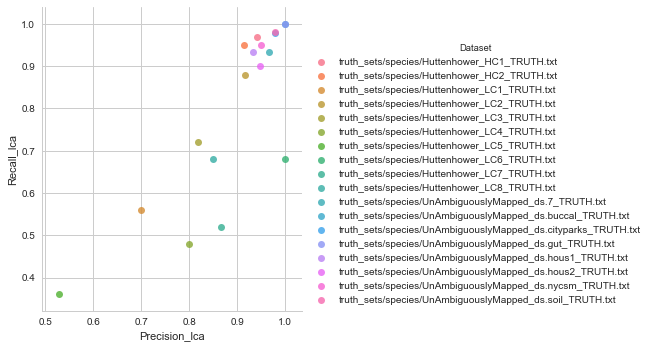

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")

g = sns.lmplot(x="Precision_lca", y="Recall_lca", hue="Dataset",
               truncate=True, size=5, data=df)

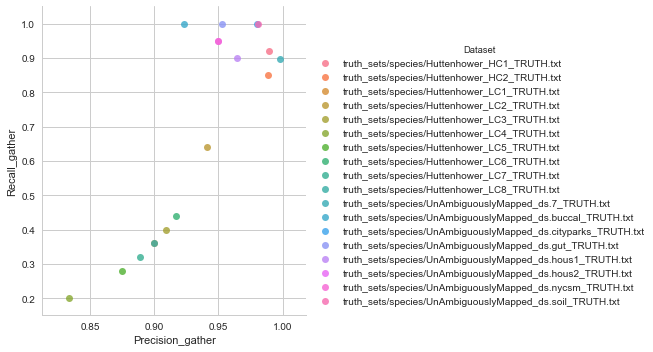

In [36]:
#sns.set(style="whitegrid")

g = sns.lmplot(x="Precision_gather", y="Recall_gather", hue="Dataset",
               truncate=True, size=5, data=df)

In [37]:
# Calculate false positives 
def compare_gather_to_truth(truth_file, gather_csv):
    truth = make_truth_lineages(truth_file)
    gather = make_gather_lineages(gather_csv)
    #print(gather)
    
    truth_lineages = set([ t[5] for t in truth ])
    gather_lineages = set([ row['lineage'] for row in gather ])
    
    print(len(truth_lineages))
    print(len(gather_lineages))
    print(len(gather_lineages - truth_lineages))
    return len(gather_lineages - truth_lineages)

false_positives = compare_gather_to_truth('truth_sets/species/Huttenhower_HC1_TRUTH.txt',
                        'output/Huttenhower_HC1.fasta.gz_reads.scaled10k.k51.gather.matches.csv')

DISAGREE: ncbi=Clostridioides difficile, truthfile=Peptoclostridium difficile
DISAGREE: ncbi=Sediminispirochaeta smaragdinae, truthfile=Spirochaeta smaragdinae
100
94
2
